# In-Depth Analysis

At this point, it's time to apply some machine learning techniques to the data and try building some predictive models. We'll start by importing the data and libraries needed to start.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB

#LightGBM
import lightgbm as lgb
import scipy as sp


/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#Import data

#File Names
adoptfile  = 'tidy_data/adoption_speed.csv'
colorfile  = 'tidy_data/color_labels.csv'
wormfile   = 'tidy_data/dewormed.csv'
breedfile  = 'tidy_data/dog_breeds.csv'
datafile   = 'tidy_data/dog_data.csv'
furfile    = 'tidy_data/fur_length.csv'
healthfile = 'tidy_data/health.csv'
sizefile   = 'tidy_data/size.csv'
statefile  = 'tidy_data/state_labels.csv'
fixedfile  = 'tidy_data/sterilized.csv'
vacfile    = 'tidy_data/vaccine.csv'

#Import Files
adptspeed  = pd.read_csv(adoptfile)
color      = pd.read_csv(colorfile)
dewormed   = pd.read_csv(wormfile)
breeds     = pd.read_csv(breedfile)
dog_data   = pd.read_csv(datafile)
fur_length = pd.read_csv(furfile)
health     = pd.read_csv(healthfile)
adult_size = pd.read_csv(sizefile)
state=pd.read_csv(statefile)
fixed = pd.read_csv(fixedfile)
vaccinated = pd.read_csv(vacfile)

In [3]:
#Separate dog_data into the original test data and training data files to work with
dogs_orig_train = dog_data[dog_data.AdoptionSpeed.notnull()]
dogs_orig_test = dog_data[dog_data.AdoptionSpeed.isnull()]

#Save dogs_train and dogs_test as files for later use 
dogs_orig_train.to_csv(r'tidy_data/dogs_orig_train.csv',index=False)
dogs_orig_test.to_csv(r'tidy_data/dogs_test.csv',index=False)

In [4]:
dogs = dogs_orig_train
dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 2100 to 10229
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8130 non-null   int64  
 1   Name           5768 non-null   object 
 2   Age            8130 non-null   int64  
 3   Breed1         8130 non-null   int64  
 4   Breed2         8130 non-null   int64  
 5   BreedCount     8130 non-null   int64  
 6   Gender         8130 non-null   int64  
 7   Color1         8130 non-null   int64  
 8   Color2         8130 non-null   int64  
 9   Color3         8130 non-null   int64  
 10  ColorCount     8130 non-null   int64  
 11  MaturitySize   8130 non-null   int64  
 12  FurLength      8130 non-null   int64  
 13  Vaccinated     8130 non-null   int64  
 14  Dewormed       8130 non-null   int64  
 15  Sterilized     8130 non-null   int64  
 16  Health         8130 non-null   int64  
 17  Quantity       8130 non-null   int64  
 18  Fee 

In [5]:
#Convert the names column to ordinal values 1 if named, 0 if not named and add a new column
pd.options.mode.chained_assignment = None  # default='warn'
dogs['Name_bool']=dogs.Name.notnull().astype(int)
dogs.head()

,index,Name,Age,Breed1,Breed2,BreedCount,Gender,Color1,Color2,Color3,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Name_bool
2100,2100,Brisco,1,307,0,1,1,2,7,0,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3.0,1
2101,2101,Miko,4,307,0,1,2,1,2,0,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2.0,1
2102,2102,Hunter,1,307,0,1,1,1,0,0,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2.0,1
2103,2103,Siu Pak,0,307,0,1,2,1,2,7,...,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9,3.0,1
2104,2104,Bear,2,307,0,1,1,1,2,7,...,1,0,41401,9238e4f44c71a75282e62f7136c6b240,0,"For serious adopter, please do sms or call for...",8b693ca84,7,1.0,1


In [6]:
#Create a boolean version of Rescuers by mapping unique Rescuer ID to the dataframe to be used later for modeling
r= pd.DataFrame() 
r['Rescuer']=dogs['RescuerID'].unique()
r['Rescuer_Int']=range(1, 2945)
s=dict(zip(r.Rescuer,r.Rescuer_Int))

dogs['RescuerInt']=dogs['RescuerID'].map(s)
dogs.head()

,index,Name,Age,Breed1,Breed2,BreedCount,Gender,Color1,Color2,Color3,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Name_bool,RescuerInt
2100,2100,Brisco,1,307,0,1,1,2,7,0,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3.0,1,1
2101,2101,Miko,4,307,0,1,2,1,2,0,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2.0,1,2
2102,2102,Hunter,1,307,0,1,1,1,0,0,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2.0,1,3
2103,2103,Siu Pak,0,307,0,1,2,1,2,7,...,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9,3.0,1,4
2104,2104,Bear,2,307,0,1,1,1,2,7,...,0,41401,9238e4f44c71a75282e62f7136c6b240,0,"For serious adopter, please do sms or call for...",8b693ca84,7,1.0,1,2


In [8]:
data = dogs.drop(['Name', 'Description','PetID','RescuerID', 'index'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 2100 to 10229
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8130 non-null   int64  
 1   Breed1         8130 non-null   int64  
 2   Breed2         8130 non-null   int64  
 3   BreedCount     8130 non-null   int64  
 4   Gender         8130 non-null   int64  
 5   Color1         8130 non-null   int64  
 6   Color2         8130 non-null   int64  
 7   Color3         8130 non-null   int64  
 8   ColorCount     8130 non-null   int64  
 9   MaturitySize   8130 non-null   int64  
 10  FurLength      8130 non-null   int64  
 11  Vaccinated     8130 non-null   int64  
 12  Dewormed       8130 non-null   int64  
 13  Sterilized     8130 non-null   int64  
 14  Health         8130 non-null   int64  
 15  Quantity       8130 non-null   int64  
 16  Fee            8130 non-null   int64  
 17  State          8130 non-null   int64  
 18  Vide

## Split the Data into Test and Train

Rather than risk an imbalance when creating a test and data set, I'll perform a test train split using stratification. This will allow for consideration of the proprtion sizes of each of the most heavily weighted features. For this project, those include Breed, Gender, Age, Name presence or Absence, and Rescuer ID. However, as each of these features have instances where only 1 number is represented, the decision was made to stratify on adoption speed.

In [9]:
#Split the data into a model test and train data set, based on rescuer ID
#First Split to save 10% of Data
dtrain, dtest = train_test_split(data, test_size = 0.1,stratify=data['AdoptionSpeed'])

Now let's verify the stratification has equal representations of adoption speed in each set. 

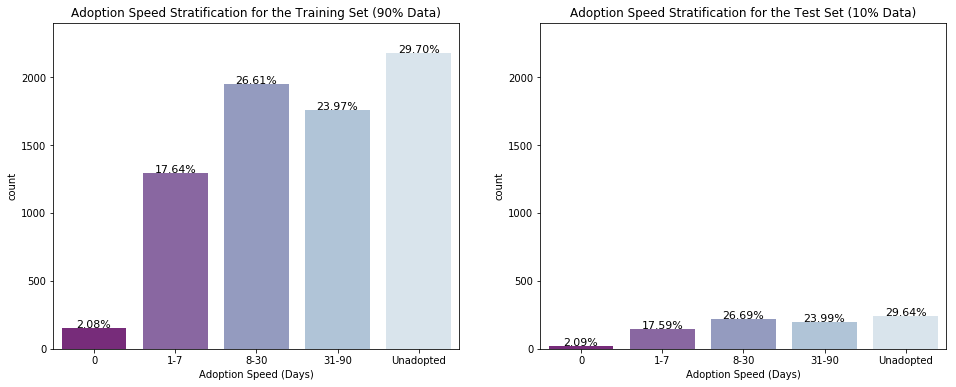

In [10]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot stratification of training set
plt.subplot(1, 2, 1)
c = sns.countplot(x='AdoptionSpeed', data=dtrain, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd) 
plt.ylim([0,2400])
plt.xlabel('Adoption Speed (Days)')
plt.title ('Adoption Speed Stratification for the Training Set (90% Data)')

#Percentages above training set 
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dtrain.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

#Plot stratification of test set 
plt.subplot(1, 2, 2)

c = sns.countplot(x='AdoptionSpeed', data=dtest, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd) 
plt.ylim([0,2400])
plt.xlabel('Adoption Speed (Days)')
plt.title ('Adoption Speed Stratification for the Test Set (10% Data)')

#Percentages above test set 
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dtest.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

plt.show()

For some model development, specific features will be chosen to test initially for speed purposes. These features will be chosen based on the results of the Statistical Data Analysis previously completed. These models will then be tested using the entirety of the dataset to determine if it performs better or worse having access to all features. 


In [11]:
#Second Split to allow for model development testing
x, y = dtrain.loc[:, dtrain.columns != 'AdoptionSpeed'], dtrain['AdoptionSpeed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify=y)

Due to the distribution of the data it may also be beneficial to drop the adoption speed of same day (category 0), and see if this is better for fitting the data, since such a small percentage (5.4%) are adopted same day. 

In [12]:
#Alternative test train split without the adoption speed = 0 to see if modeling is better
data_alt = data[data['AdoptionSpeed']!= 0.0]

#First Split to save 10% of Data
dtrain_alt, dtest_alt = train_test_split(data_alt, test_size = 0.1,stratify=data_alt['AdoptionSpeed'])

#Second Split to allow for model development testing
x_a, y_a = dtrain.loc[:, dtrain_alt.columns != 'AdoptionSpeed'], dtrain['AdoptionSpeed']

xa_train, xa_test, ya_train, ya_test = train_test_split(x_a, y_a, test_size=0.25, random_state=1, stratify=y)

data_alt['AdoptionSpeed'].unique()

array([3., 2., 1., 4.])

## Logistic Regression

It's time to choose some Machine Learning models to apply to this data set. 

Application of a regression model may not yield great results, because several of the variables have non-linear relationships. However, it doesn't hurt to verify this. It's also entirely possible that a combination model using regression may prove useful. 

The model will be built by further splitting the test set, to ensure that the initial train data set doesn't lead to overfitting.  

In [20]:
logRegr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 10000)

#Test the model on the highest correlated features 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr.predict(xtestlr), ytestlr))

0.3777322404371585


While it looks like the best choice is to perform regression on a combination of Breed, Age, and Rescuer ID, the result is still not very good. Let's expolore different solver options for the model and see if one is a better choice than the others before we apply this model to the entire set of features. 


In [21]:
#create model instance
logRegr1 = LogisticRegression(solver='newton-cg',multi_class='ovr',max_iter=900000000)
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr1.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr1.predict(xtestlr), ytestlr))

0.375


Because of the very large number of maximum interations necessary to ensure convergence, so this would not be an ideal choice for our model, and the score is the same as the default solver. 

In [12]:
#create model instance
logRegr2 = LogisticRegression(solver='liblinear',multi_class='ovr')
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr2.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr2.predict(xtestlr), ytestlr))

0.3770491803278688


In [23]:
#create model instance
logRegr3 = LogisticRegression(solver='saga',multi_class='ovr',max_iter=1000000)
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr3.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr3.predict(xtestlr), ytestlr))

0.36133879781420764


So it looks like the best choices for logistic regression is the either the default or the liblinear solver. Even using these choices an improved model will be needed, so let's explore some other options. 

Before moving on to a new model, let's try optimizing the one we're working with by optimizing the C parameter.

K-fold cross validation was deliberatly not utilized here because of the imbalanced classifications and the small number of data points in some groups as compared to others, which would likely lead to accuracy errors. 

In [24]:
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
#logRegr.fit(xlr, ylr)


#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
C_scores=[]

for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(xtestlr,ytestlr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.36133879781420764, 0.38046448087431695, 0.38046448087431695, 0.3790983606557377, 0.3777322404371585]
Best score:  0.38046448087431695
C value that yields best score = 0.1


In [25]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr')
    fit = clf.fit(xtestlr,ytestlr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.38046448087431695, 0.3770491803278688, 0.3790983606557377, 0.3790983606557377, 0.3790983606557377]
Best score:  0.38046448087431695
C value that yields best score = 0.001


Testing on both the solvers, it looks like both give the same accuracy socre of 0.3805 yielded by optmizing the C value. Both scores are improved by tuning the hyperparameter C. 

Let's now perform testing using both the liblinear and the default (lbfgs) solvers and access to all the features in the data set to see if the score can be further improved. 

In [15]:
logRegr2.fit(x_train, y_train)
#Print Accuracy
print('Logistic Regression, all features', accuracy_score(logRegr2.predict(x_test), y_test))

Logistic Regression, all features 0.3633879781420765


In [16]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr', max_iter=10000)
    fit = clf.fit(x_test,y_test)
    score = accuracy_score(clf.predict(x_test), y_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.3743169398907104, 0.3726775956284153, 0.37814207650273224, 0.3737704918032787, 0.37540983606557377]
Best score:  0.37814207650273224
C value that yields best score = 1


In [17]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(x_test,y_test)
    score = accuracy_score(clf.predict(x_test), y_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.36775956284153005, 0.35081967213114756, 0.3448087431693989, 0.3622950819672131, 0.35792349726775957]
Best score:  0.36775956284153005
C value that yields best score = 0.001


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
logRegr2.fit(x_train, y_train)
y_pred = logRegr2.predict(x_test)
print(confusion_matrix(y_test,y_pred))


[[  0   6   9   5  18]
 [  0  47 129  45 102]
 [  0  22 228  70 167]
 [  0  17 190  79 153]
 [  0  20 170  42 311]]


So the best model for linear regression is found using an lbfgs solver with a C-value of 10. This is potentially not the best option, given the large number of maximum iterations. So both options may be considered if ensembling is used later. 

Results

| Model | Accuracy Score | C-Value | Solver| 
| --- | --- | --- | --- |
|Logistic Regression| 0.38525 |0.1| lbfgs| 
|Logistic Regression| 0.38798| 1.0 | liblinear


Let's try one more analysis to see if removing the adoption speed classification for same day adoptions improves any of the model performance.

In [13]:
logRegr2.fit(xa_train, ya_train)
#Print Accuracy
print('Logistic Regression, all features', accuracy_score(logRegr2.predict(xa_test), ya_test))

Logistic Regression, all features 0.3633879781420765


In [14]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr', max_iter=10000)
    fit = clf.fit(xa_test,ya_test)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.3743169398907104, 0.3726775956284153, 0.37814207650273224, 0.3737704918032787, 0.37540983606557377]
Best score:  0.37814207650273224
C value that yields best score = 1


In [51]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(xa_test,ya_test)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.3743169398907104, 0.36721311475409835, 0.3743169398907104, 0.37814207650273224, 0.3743169398907104]
Best score:  0.37814207650273224
C value that yields best score = 10


Original Data

| Model | Accuracy Score | C-Value | Solver| 
| --- | --- | --- | --- |
|Logistic Regression| 0.38525 |0.1| lbfgs| 
|Logistic Regression| *0.38798*| 1.0 | liblinear



After removing Adoption Class of Same Day Adoptions

| Model | Accuracy Score | C-Value | Solver| 
| --- | --- | --- | --- |
|Logistic Regression| 0.38524 |0.1| lbfgs| 
|Logistic Regression| 0.37814| 10 | liblinear

So it appears the best model, if using logistic regression, is by using the liblinear model and a C-value of 1.0 on the full dataset. Removal of the 5% of dogs adopted on the same day as they were listed actually decreased the accuracy of the model. 

# Naive Bayes

Let's now try applying Naive Bayes.

Multinomial Naive Bayes will be used because the bulk of the data is categorical, and it tends to not be normally distributed. Gaussian was considered but because of the mix of variables, it was decided that the best choice would be multinomial. The benefit of using Naive Bayes is that it assumes the independence of each feature in the data set, and will hopefully find any instances where a particular feature has more weight than the others. This typically considered is one of the better intial choices for an "off the shelf" supervised learning algorithm, which is why it's being considered.

In [13]:
#Define the Model 
NBclf = MultinomialNB()

#Fit the Model 
NBclf_fit = NBclf.fit(x_train,y_train)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_fit.score(x_train,y_train))
print ('Testing Data Accuracy:  ', NBclf_fit.score(x_test,y_test))

Training Data Accuracy:  0.2285401858939311
Testing Data Accuracy:   0.22349726775956283


In [22]:
y_pred = NBclf.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[ 19   1   6   9   3]
 [100  14 117  66  26]
 [102  17 233  99  36]
 [ 88  10 204 107  30]
 [168  17 201  95  62]]


This result is less accurate than the logistic regression model, so it's probably not worth pursing hyperparameter tuning. However, additional models will be explored and Naive Bayes can be returned to in the event that it proves more accurate than other choices. It is unlikely to be more accurate simply because of the lack of linearity in the dataset. 

In [76]:
# Repeat with adoption speed != 0 data 

#Fit the Model 
NBclf_fit = NBclf.fit(xa_train,ya_train)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_fit.score(xa_train,ya_train))
print ('Testing Data Accuracy:  ', NBclf_fit.score(xa_test,ya_test))

Training Data Accuracy:  0.23510114816839803
Testing Data Accuracy:   0.19289617486338798


There is no difference between models here if you remove the same day adoption set of animals, likely because of the assumptions of independence between features.

| Model | Accuracy Score | 
| --- | --- | 
|Logistic Regression-liblinear| 0.38798| 
|Logistic Regression-lbfgs| 0.38525 |
|Naive Bayes | 0.19290| 



# Support Vector Machines

*** ENTER SOME TEXT HERE***

## Linear SVC

In [24]:
from sklearn.svm import LinearSVC

#Create the model
Lsvc = LinearSVC(random_state = 0, max_iter = 10000)


#Test model on data 
Lsvc.fit(x_train, y_train)

#Print results
print ('Linear SVC all features', Lsvc.score(x_test,y_test))

Linear SVC all features 0.17650273224043717


/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
y_pred = Lsvc.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[  0  38   0   0   0]
 [  0 323   0   0   0]
 [  0 487   0   0   0]
 [  0 439   0   0   0]
 [  0 543   0   0   0]]


| Model | Score | 
| --- | --- | 
|Logistic Regression-lbfgs| 0.38524 |
|Logistic Regression-liblinear| 0.38797| 
|Naive Bayes | 0.19289| 
|Linear SVC| 0.23989 |

## Nonlinear SVC

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svclassifier = SVC(gamma='auto')

#All Features 
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


print('Accuracy Score', svclassifier.score(x_test,y_test))

[[  1   2   1   4  30]
 [  0  30  62  24 207]
 [  0  15 122  69 281]
 [  0   8  93  84 254]
 [  0   6  32  28 477]]
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.05        38
         1.0       0.49      0.09      0.16       323
         2.0       0.39      0.25      0.31       487
         3.0       0.40      0.19      0.26       439
         4.0       0.38      0.88      0.53       543

    accuracy                           0.39      1830
   macro avg       0.53      0.29      0.26      1830
weighted avg       0.42      0.39      0.33      1830

Accuracy Score 0.3901639344262295


Repeat with alternative test set to determine effect of same day adoption on model. 

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svclassifier = SVC(gamma='auto', kernel='linear')

#All Features 
svclassifier.fit(xa_train, ya_train)
ya_pred = svclassifier.predict(xa_test)


print(confusion_matrix(ya_test,ya_pred))
print(classification_report(ya_test,ya_pred))


print('Accuracy Score', svclassifier.score(xa_test,ya_test))

[[  0   1   1  23  13]
 [  0  41  32 173  77]
 [  0  22  38 322 105]
 [  0  22  37 285  95]
 [  0  30  73 229 211]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.35      0.13      0.19       323
         2.0       0.21      0.08      0.11       487
         3.0       0.28      0.65      0.39       439
         4.0       0.42      0.39      0.40       543

    accuracy                           0.31      1830
   macro avg       0.25      0.25      0.22      1830
weighted avg       0.31      0.31      0.28      1830



/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy Score 0.31420765027322406


| Model | Score | 
| --- | --- | 
|Logistic Regression-lbfgs| 0.38524 |
|Logistic Regression-liblinear| 0.38797| 
|Naive Bayes | 0.19289| 
|Linear SVC| 0.23989 |
|SVM| 0.31421| 


# K Nearest Neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier

#Split Data
xtrain, xtest, ytrain, ytest = train_test_split(dtrain[['RescuerInt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)


kNN=KNeighborsClassifier()

kNN.fit(x_train,y_train)
print ('KNN Score all features', kNN.score(x_test,y_test))

kNN.fit(xtrain,ytrain)
print ('KNN Score Specific Features', kNN.score(xtest,ytest))


KNN Score all features 0.37814207650273224
KNN Score Specific Features 0.34494535519125685


In [31]:
kNN.fit(x_train,y_train)
y_pred = kNN.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[  5  13   6   5   9]
 [  3 118 108  49  45]
 [  7 124 179 101  76]
 [  5  86 158 121  69]
 [  4  82 112  76 269]]


In [57]:
# Repeat for non same day adoptions 

kNN=KNeighborsClassifier()


kNN.fit(xa_train,ya_train)
print ('KNN Score Adoption Speeds Not Same Day', kNN.score(xa_test,ya_test))

KNN Score Adoption Speeds Not Same Day 0.37103825136612023


**UPDATE THIS**


| Model | Score | 
| --- | --- | 
|Logistic Regression-lbfgs| 0.39125 |
|Logistic Regression-liblinear| 0.38798| 
|SVM| 0.38689|
|KNN| 0.329235|
|Naive Bayes | 0.37104 | 
|Linear SVC| 0.23989 |

# Random Forest 

In [32]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state = 0, n_estimators = 10)

#Test model on all features
RF.fit(x_train, y_train)
print ('Random Forest Score all features', RF.score(x_test,y_test))


#Test model on adoption speeds other than same day
RF.fit(xa_train, ya_train)
print ('Random Forest Score Adoption Not Zero', RF.score(xa_test,ya_test))

Random Forest Score all features 0.41420765027322404
Random Forest Score Adoption Not Zero 0.41420765027322404


So far this is the best model, so it would likely be beneficial to pursue some hyperparameter tuning on the Random Forest Model. Let's start by tuning n_estimators. 

In [33]:
#the grid of parameters to search over
Ns = [1, 10, 50, 100, 110, 120, 130, 140, 150]

# initialize an empty array 
N_scores=[]

#Run model over each C value in Cs
for param in Ns:
    RF = RandomForestClassifier(random_state = 0, n_estimators = param)
    RF.fit(x_train, y_train)
    score = RF.score(x_test,y_test)
    N_scores.append(score)

max_score = max(N_scores)
max_idx = N_scores.index(max(N_scores))
highest_N = Ns[max_idx]

print('N-Estimators Values: ' , N_scores)
print("Best score: ", max_score)
print("N-estimator value that yields best score =", highest_N)

N-Estimators Values:  [0.34153005464480873, 0.41420765027322404, 0.4530054644808743, 0.45792349726775955, 0.4562841530054645, 0.4540983606557377, 0.4562841530054645, 0.4546448087431694, 0.45737704918032784]
Best score:  0.45792349726775955
N-estimator value that yields best score = 100


In [34]:
RF = RandomForestClassifier(random_state = 0, n_estimators = 100)
RF.fit(x_train,y_train)
y_pred = RF.predict(x_test)
print(confusion_matrix(y_test,y_pred))

[[  1  11   9   8   9]
 [  0 112  98  37  76]
 [  0  76 190 106 115]
 [  0  41 123 150 125]
 [  1  29  68  60 385]]


In [65]:
#the grid of parameters to search over
Ns = [1, 10, 50, 100, 110, 120, 130, 140, 150]

# initialize an empty array 
N_scores=[]

#Run model over each C value in Cs
for param in Ns:
    RF = RandomForestClassifier(random_state = 0, n_estimators = param)
    RF.fit(xa_train, ya_train)
    score = RF.score(xa_test,ya_test)
    N_scores.append(score)

max_score = max(N_scores)
max_idx = N_scores.index(max(N_scores))
highest_N = Ns[max_idx]

print('N-Estimators Values: ' , N_scores)
print("Best score: ", max_score)
print("N-estimator value that yields best score =", highest_N)

N-Estimators Values:  [0.3371584699453552, 0.41147540983606556, 0.45901639344262296, 0.4562841530054645, 0.460655737704918, 0.45901639344262296, 0.46174863387978143, 0.4644808743169399, 0.46174863387978143]
Best score:  0.4644808743169399
N-estimator value that yields best score = 140


In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y, classes = [0,1,2,3,4])
n_classes = 5

xr_train, xr_test, yr_train, yr_test =\
    train_test_split(x, y, test_size=0.25, random_state=1)




<class 'pandas.core.series.Series'>


In [ ]:
y_prob = RF.predict_proba(x_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

*/*update this*/*

| Model | Score | 
| --- | --- | 
|Random Forest| 0.46011| 
|Logistic Regression-lbfgs| 0.39125 |
|Logistic Regression-liblinear| 0.38798| 
|SVM| 0.38689|
|KNN| 0.32924|
|Naive Bayes | 0.25792 | 
|Linear SVC| .023989 |


# Light GBM

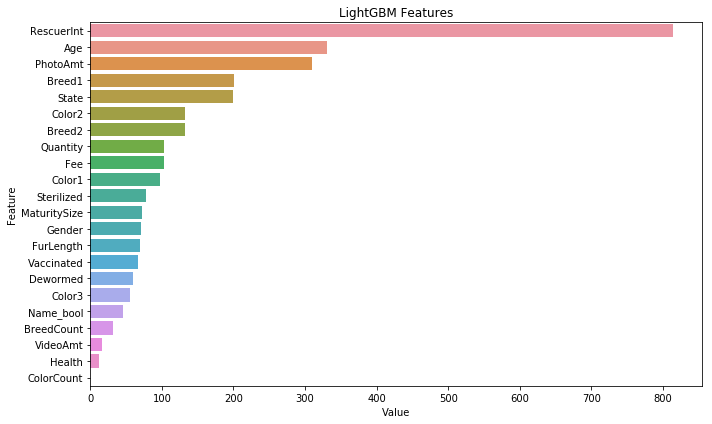

In [68]:
from sklearn.feature_selection import SelectFromModel
model = lgb.LGBMRegressor()
model.fit(x_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()


features_selection = SelectFromModel(model, threshold='1.25*median') # The Threshold is the median of features importance*1.25 
features_selection.fit(x_train, y_train)


features_selection_support = features_selection.get_support()
features_selection = x_train.loc[:,features_selection_support].columns.tolist()

In [71]:
lgb_params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'learning_rate': 0.005,
'subsample': .8,
'colsample_bytree': 0.8,
'min_split_gain': 0.006,
'min_child_samples': 150,
'min_child_weight': 0.1,
'max_depth': 17,
'n_estimators': 5000,
'num_leaves': 80,
}
lgb_model = lgb.LGBMRegressor(**lgb_params)

lgb_model.fit(x_train,y_train)

#Prediction
y_pred=lgb_model.predict(x_train.values)
print ('LightGBM Score all features', lgb_model.score(x_test,y_test)) 

LightGBM Score all features 0.20096462645474045


In [69]:
lgb_params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'learning_rate': 0.005,
'subsample': .8,
'colsample_bytree': 0.8,
'min_split_gain': 0.006,
'min_child_samples': 150,
'min_child_weight': 0.1,
'max_depth': 17,
'n_estimators': 5000,
'num_leaves': 80,
}
lgb_model = lgb.LGBMRegressor(**lgb_params)

lgb_model.fit(xa_train,ya_train)

#Prediction
y_pred=lgb_model.predict(xa_train.values)
print ('LightGBM Score all features', lgb_model.score(xa_test,ya_test))

LightGBM Score all features 0.20096462645474045


# Model Scores 

| Model | Accuracy Score | 
| --- | --- | 
|Random Forest| 0.46011| 
|Logistic Regression-lbfgs| 0.39125 |
|Logistic Regression-liblinear| 0.38798| 
|SVM| 0.38689|
|KNN| 0.32924|
|Naive Bayes | 0.25792 | 
|LightGBM | 0.24760 |
|Linear SVC| 0.23989 |

# Pipeline


# Receiver Operating Characteristic (ROC)

In [49]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [50]:
y_bin = label_binarize(y, classes = [0,1,2,3,4])
n_classes = 5

xr_train, xr_test, yr_train, yr_test =\
    train_test_split(x, y, test_size=0.25, random_state=1)





In [51]:
# Learn to predict each class against the other
#svclassifier
classifier = OneVsRestClassifier(SVC(gamma='auto', kernel='linear'))#, probability=True,
                                # random_state=0))


In [ ]:
y_score = classifier.fit(xr_train, yr_train).decision_function(xr_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_prob = classifier.predict_proba(x_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))